/var/folders/2m/6jtrps0d7n9gs5v3067trbzw0000gn/T/ipykernel_67257/3372709069.py:104: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  s = s.resample("0.1S").mean().interpolate("time")
/var/folders/2m/6jtrps0d7n9gs5v3067trbzw0000gn/T/ipykernel_67257/3372709069.py:104: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  s = s.resample("0.1S").mean().interpolate("time")


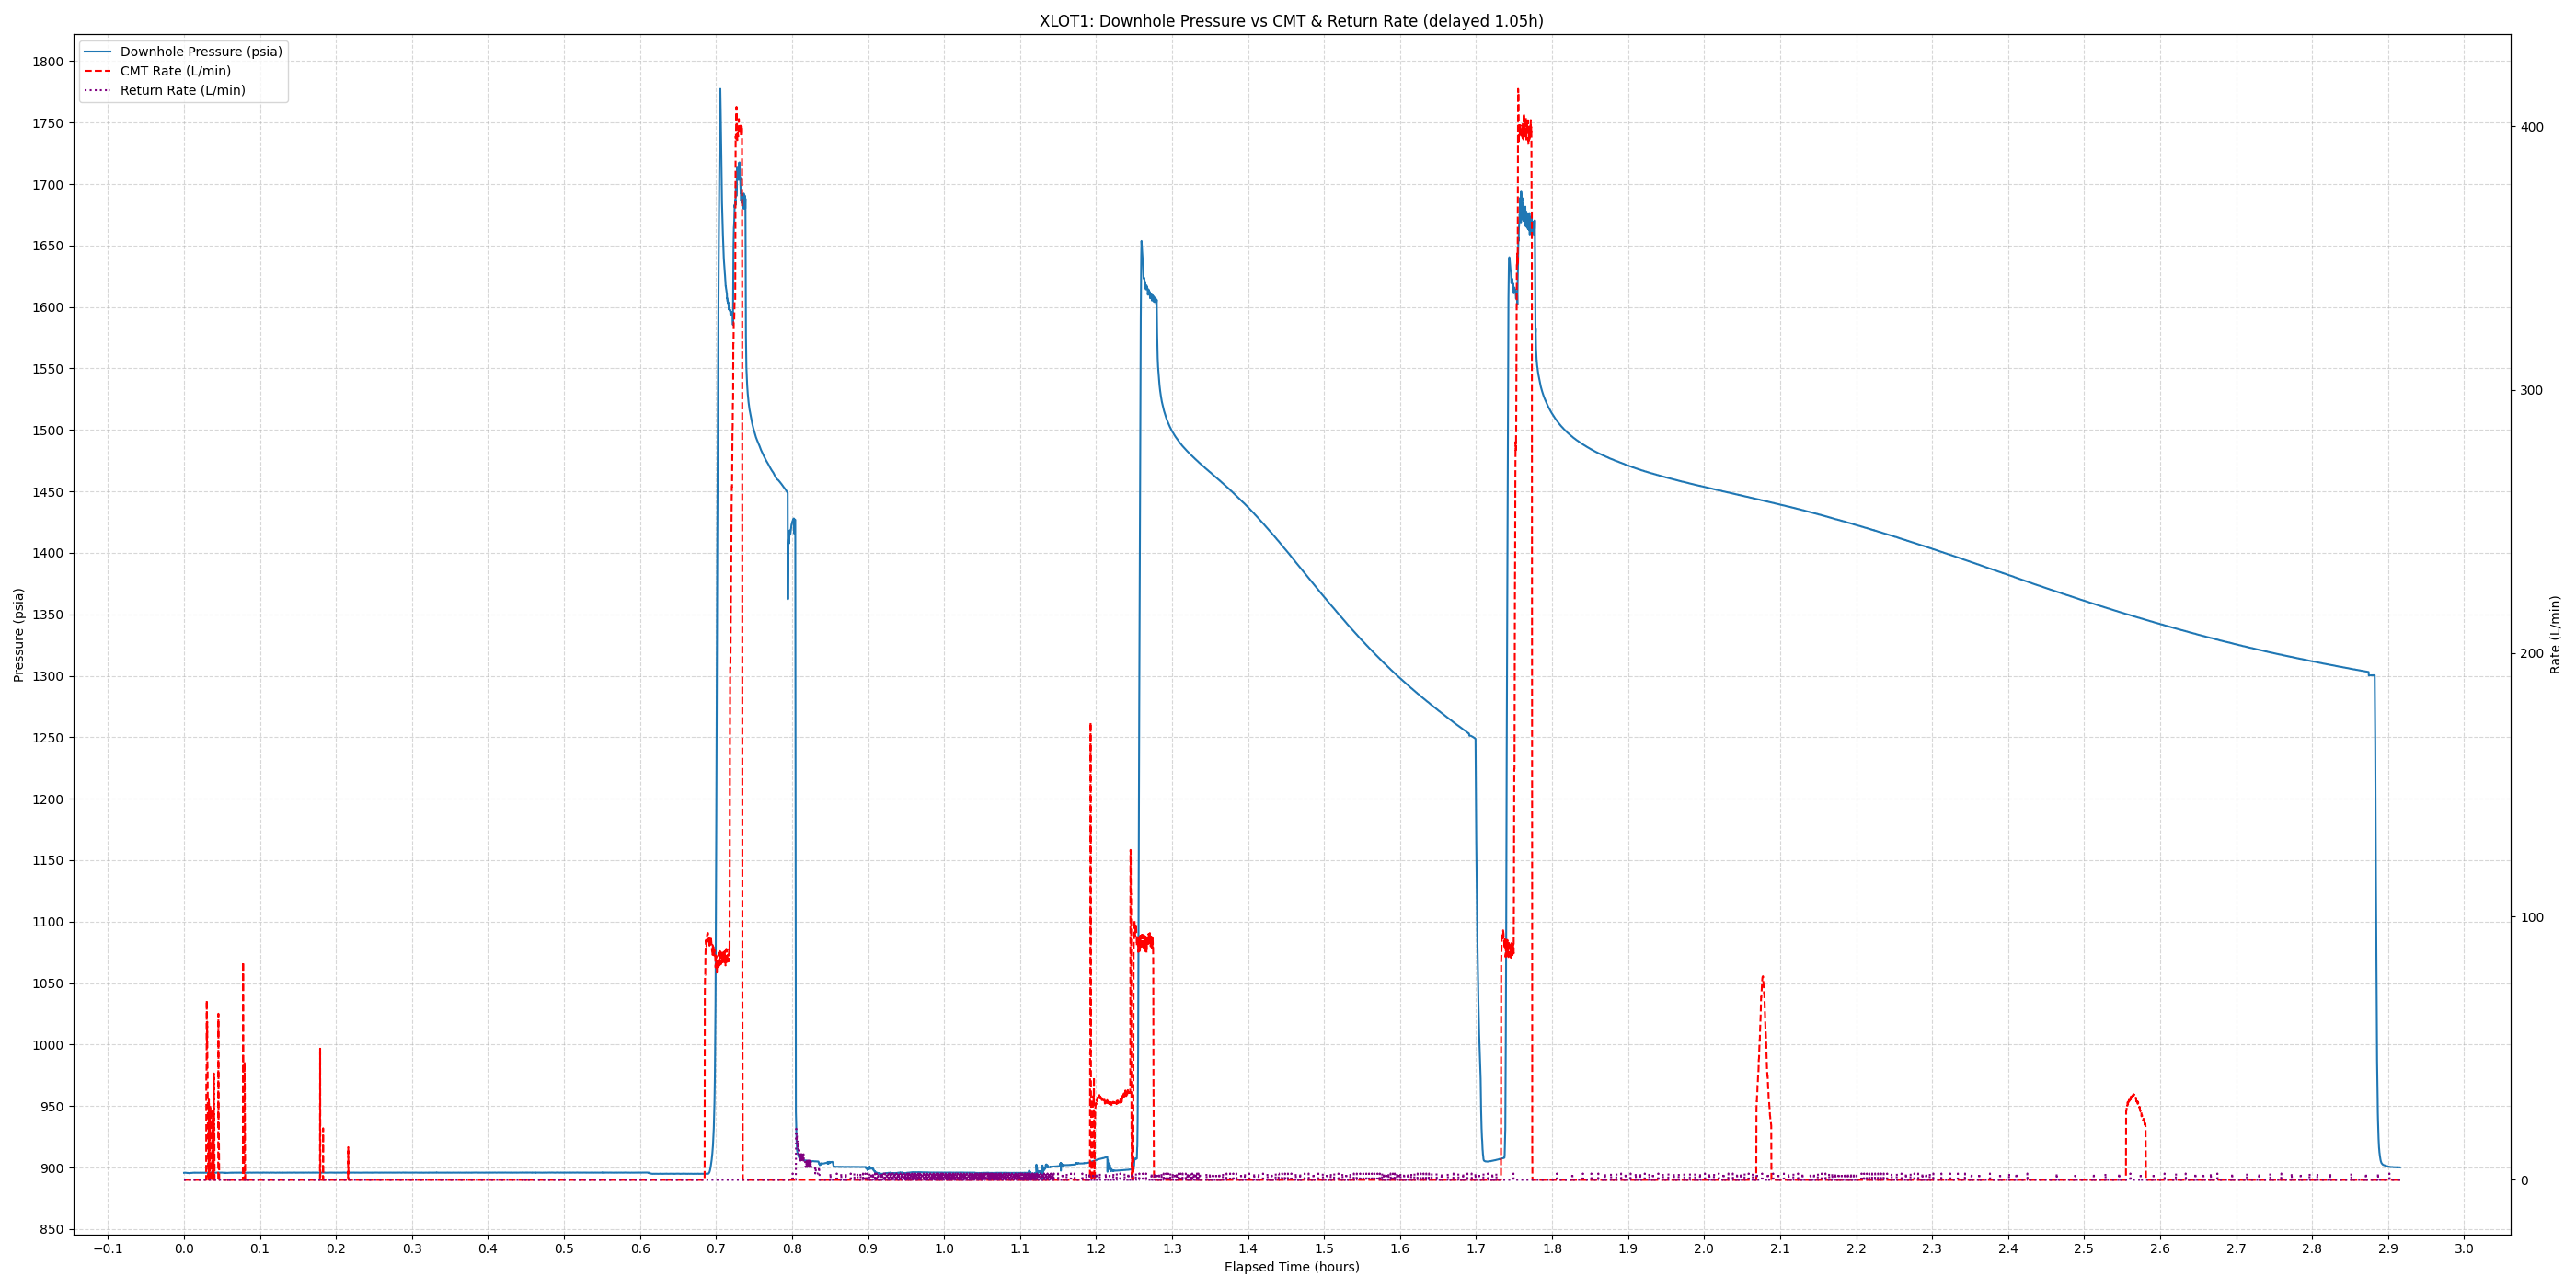

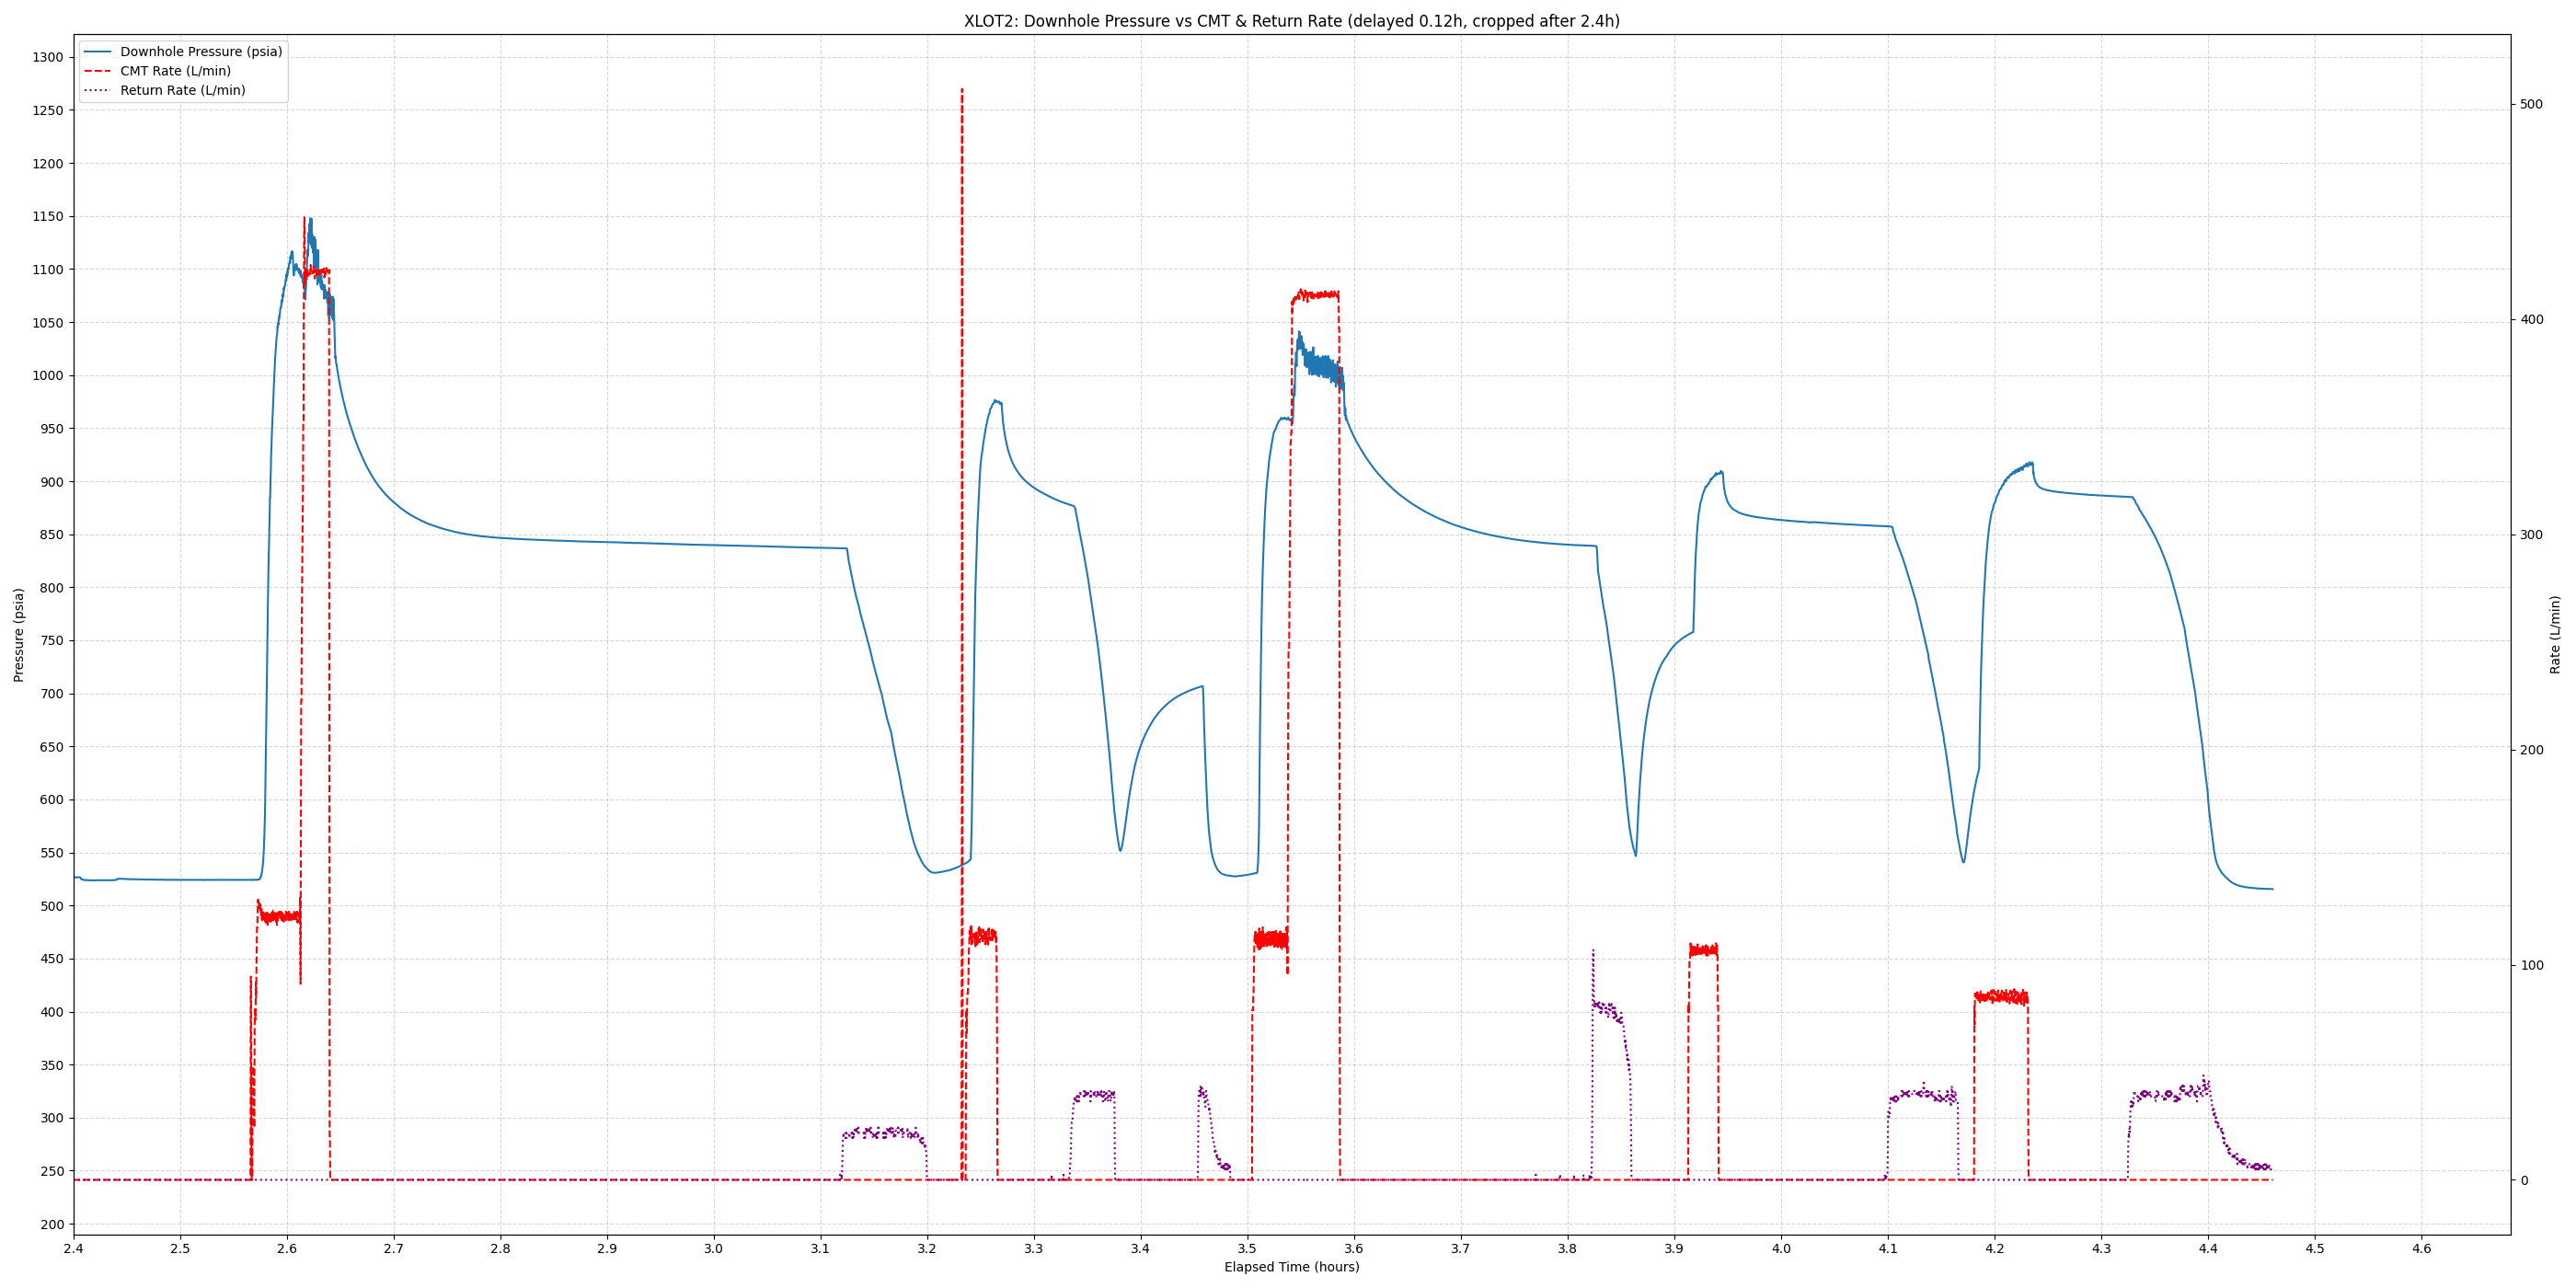

In [4]:
import pandas as pd
import re
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# ---- File paths
gauge_fp = "Data/XLOT_minifrac/Oranjeoord/NLOG_GS_PUB_ORO-01_XLOT1+2 zip/ORO-01_XLOT1_and_XLOT2_DownholeGauge_1samplesperS_DC8908.txt"
xlot1_fp = "Data/XLOT_minifrac/Oranjeoord/NLOG_GS_PUB_ORO-01_XLOT1+2 zip/ORO_01_Xlot1_Cementing_Unit_data.txt"
xlot2_fp = "Data/XLOT_minifrac/Oranjeoord/NLOG_GS_PUB_ORO-01_XLOT1+2 zip/ORO_01_Xlot2_Cementing_Unit_data.txt"

%matplotlib widget

# ---- Helper: parse gauge file
def parse_gauge(fp, start_str="05:16:2024:15:32:28"):
    # Find header
    header_line_idx = None
    with open(fp, "r", encoding="utf-8", errors="ignore") as f:
        for i, line in enumerate(f):
            if line.strip().startswith("Elapsed Time"):
                header_line_idx = i
                break
    if header_line_idx is None:
        raise RuntimeError("Could not find 'Elapsed Time' in gauge file.")
    skiprows = header_line_idx + 2

    df = pd.read_csv(fp, sep="\t", skiprows=skiprows, header=None,
                     names=["ElapsedHours", "Pressure_psia", "Temperature_degC"])
    df["ElapsedHours"] = pd.to_numeric(df["ElapsedHours"], errors="coerce")
    df = df.dropna(subset=["ElapsedHours"]).reset_index(drop=True)

    start_dt = datetime.strptime(start_str, "%m:%d:%Y:%H:%M:%S")
    df["DateTime"] = pd.to_datetime(
        [start_dt + timedelta(hours=float(h)) for h in df["ElapsedHours"]]
    )

    return df[["DateTime", "Pressure_psia"]]

# ---- Helper: parse cementing file robustly
_time_pat = re.compile(r"^\d{2}:\d{2}:\d{4}:\d{2}:\d{2}:\d{2}$")

def robust_read_cmt(fp):
    rows = []
    with open(fp, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            parts = line.rstrip("\n").split("\t")
            if not parts:
                continue
            if _time_pat.fullmatch(parts[0].strip()):
                rows.append(parts)

    from collections import Counter
    expected = Counter(len(r) for r in rows).most_common(1)[0][0]
    rows = [r[:expected] + [""] * (expected - len(r)) if len(r) != expected else r for r in rows]

    # Columns as they typically appear (we cap by expected)
    cols = ["Time", "CMT RATE", "CMT VOL", "CMT TREAT PRES", "PUMP PRESSURE",
            "CMT RATE RETURN", "RETURNNRD"][:expected]
    df = pd.DataFrame(rows, columns=cols)

    # Parse timestamps
    df["DateTime"] = pd.to_datetime(df["Time"], format="%m:%d:%Y:%H:%M:%S", errors="coerce")

    # Numeric parsing with comma-as-decimal fallback
    def to_num(s):
        return pd.to_numeric(pd.Series(s).astype(str).str.replace(",", ".", regex=False), errors="coerce")

    # Main injection rate
    df["CMT_RATE_Lmin"] = to_num(df["CMT RATE"]) if "CMT RATE" in df.columns else pd.NA
    # RETURN rate (column 6)
    df["RETURN_RATE_Lmin"] = to_num(df["CMT RATE RETURN"]) if "CMT RATE RETURN" in df.columns else pd.NA

    return (
        df[["DateTime", "CMT_RATE_Lmin", "RETURN_RATE_Lmin"]]
        .dropna(subset=["DateTime"])
        .sort_values("DateTime")
        .reset_index(drop=True)
    )

# ---- Load data
gauge_df = parse_gauge(gauge_fp)
xlot1_df = robust_read_cmt(xlot1_fp)
xlot2_df = robust_read_cmt(xlot2_fp)

# ---- Apply delays to cementing rates
xlot1_df["DateTime"] = xlot1_df["DateTime"] + pd.to_timedelta(1.036, unit="h")  # +1.05 h
xlot2_df["DateTime"] = xlot2_df["DateTime"] + pd.to_timedelta(1.036, unit="h")  #

# ---- Split gauge data to match time windows
def subset_window(gauge, start_dt, end_dt):
    return gauge[(gauge["DateTime"] >= start_dt) & (gauge["DateTime"] <= end_dt)].copy()

x1_start, x1_end = xlot1_df["DateTime"].min(), xlot1_df["DateTime"].max()
x2_start, x2_end = xlot2_df["DateTime"].min(), xlot2_df["DateTime"].max()

gauge_x1 = subset_window(gauge_df, x1_start, x1_end)
gauge_x2 = subset_window(gauge_df, x2_start, x2_end)

# ---- Resample gauge data to 1s
def resample_seconds(df):
    if df.empty:
        return df
    s = df.set_index("DateTime")["Pressure_psia"].sort_index()
    s = s.resample("0.1S").mean().interpolate("time")
    return s.reset_index()

gauge_x1_rs = resample_seconds(gauge_x1)
gauge_x2_rs = resample_seconds(gauge_x2)

# ---- Plot with elapsed hours on x-axis, ticks every 0.1h, pressure grid every 200 psia
def plot_pressure_vs_rate_red(gauge_seg, cmt_seg, title, out_path, crop_start=None):
    if gauge_seg.empty or cmt_seg.empty:
        print(f"Skipping {title}, one of the datasets is empty.")
        return

    # establish common reference start time
    t0 = min(gauge_seg["DateTime"].min(), cmt_seg["DateTime"].min())

    # compute elapsed hours
    g_hours = (gauge_seg["DateTime"] - t0).dt.total_seconds() / 3600.0
    c_hours = (cmt_seg["DateTime"] - t0).dt.total_seconds() / 3600.0

    fig, ax1 = plt.subplots(figsize=(28, 14))

    # Left y-axis: Pressure
    ax1.plot(g_hours, gauge_seg["Pressure_psia"], label="Downhole Pressure (psia)")
    ax1.set_xlabel("Elapsed Time (hours)")
    ax1.set_ylabel("Pressure (psia)")

    # X ticks every 0.1 h + grid
    ax1.xaxis.set_major_locator(mticker.MultipleLocator(0.1))
    ax1.grid(True, which="major", axis="x", linestyle="--", alpha=0.5)

    # Y ticks (pressure) every 200 psia + grid (these are horizontal grid lines)
    ax1.yaxis.set_major_locator(mticker.MultipleLocator(50))
    ax1.grid(True, which="major", axis="y", linestyle="--", alpha=0.5)

    # Right y-axis: Rates
    ax2 = ax1.twinx()
    ax2.plot(c_hours, cmt_seg["CMT_RATE_Lmin"],
             linestyle="--", color="red", label="CMT Rate (L/min)")
    ax2.plot(c_hours, cmt_seg["RETURN_RATE_Lmin"],
             linestyle=":", color="purple", label="Return Rate (L/min)")
    ax2.set_ylabel("Rate (L/min)")

    # Apply crop if requested (on elapsed hours)
    if crop_start is not None:
        ax1.set_xlim(left=crop_start)

    # Combined legend
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1 + h2, l1 + l2, loc="upper left")

    ax1.set_title(title)
    plt.tight_layout()
    plt.savefig(out_path, dpi=150, bbox_inches="tight")
    plt.show()

# ---- Generate plots
plot_pressure_vs_rate_red(
    gauge_x1_rs, xlot1_df,
    "XLOT1: Downhole Pressure vs CMT & Return Rate (delayed 1.05h)",
    "xlot1_pressure_vs_cmt_and_return_rate.png"
)

plot_pressure_vs_rate_red(
    gauge_x2_rs, xlot2_df,
    "XLOT2: Downhole Pressure vs CMT & Return Rate (delayed 0.12h, cropped after 2.4h)",
    "xlot2_pressure_vs_cmt_and_return_rate.png",
    crop_start=2.4
)


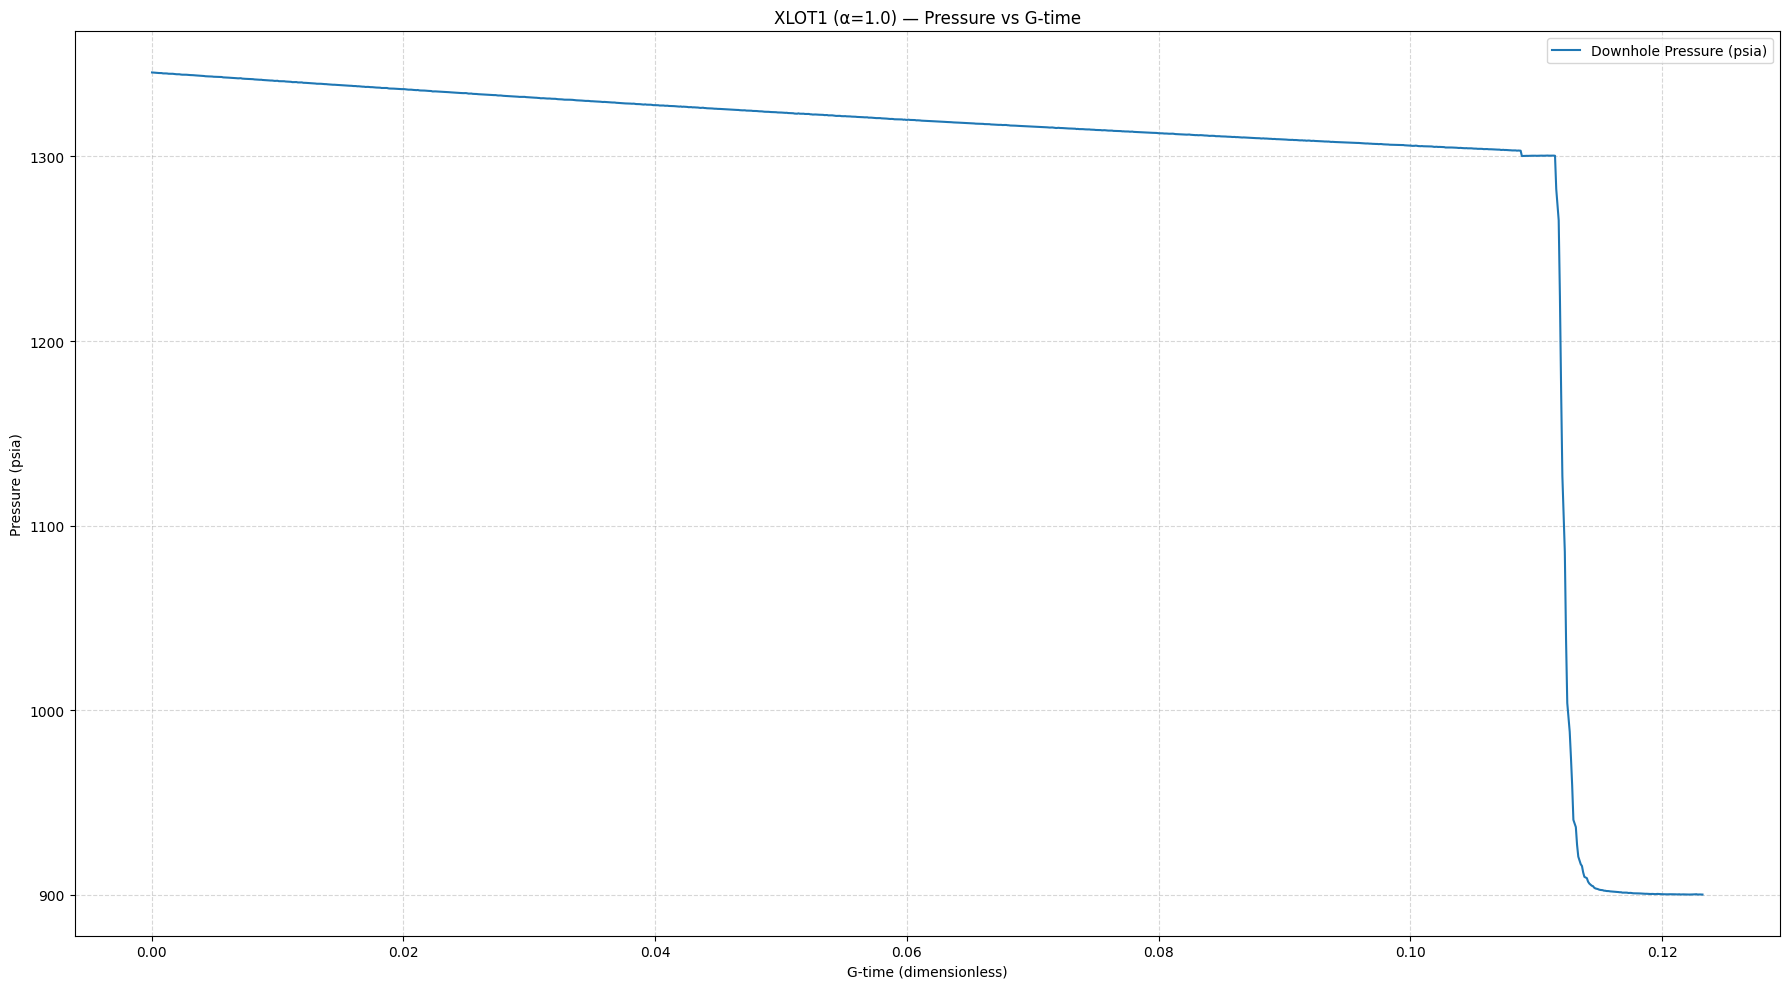

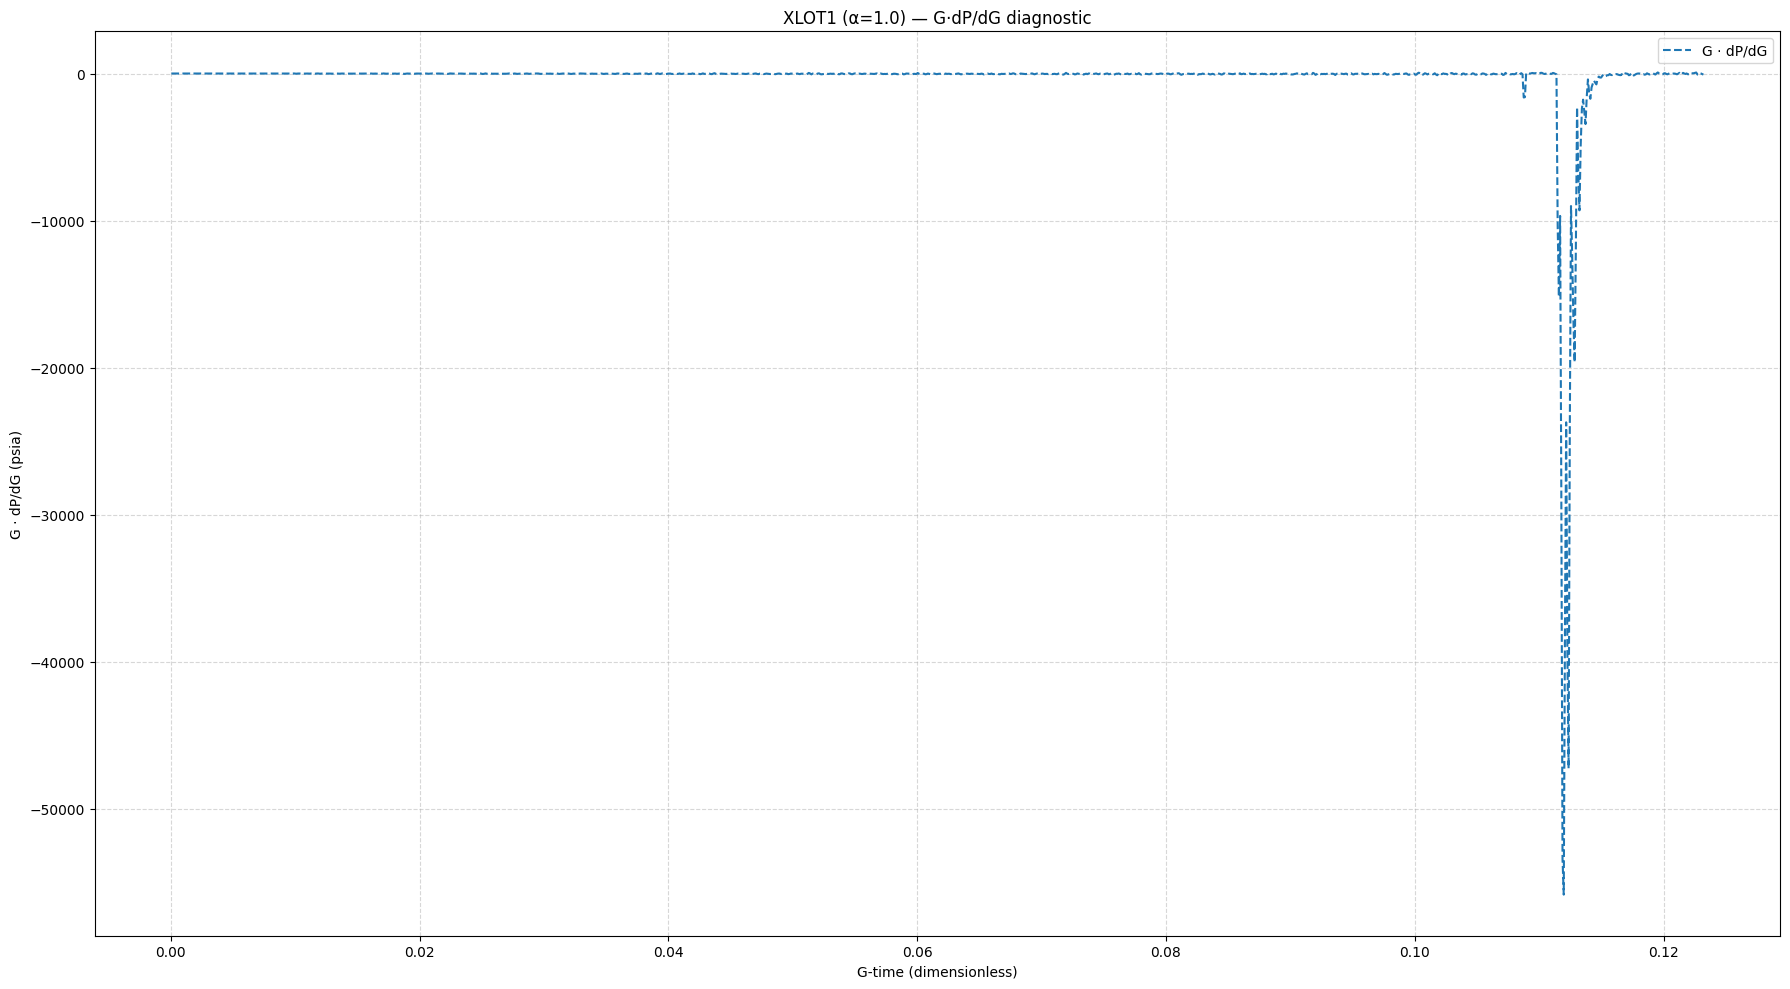

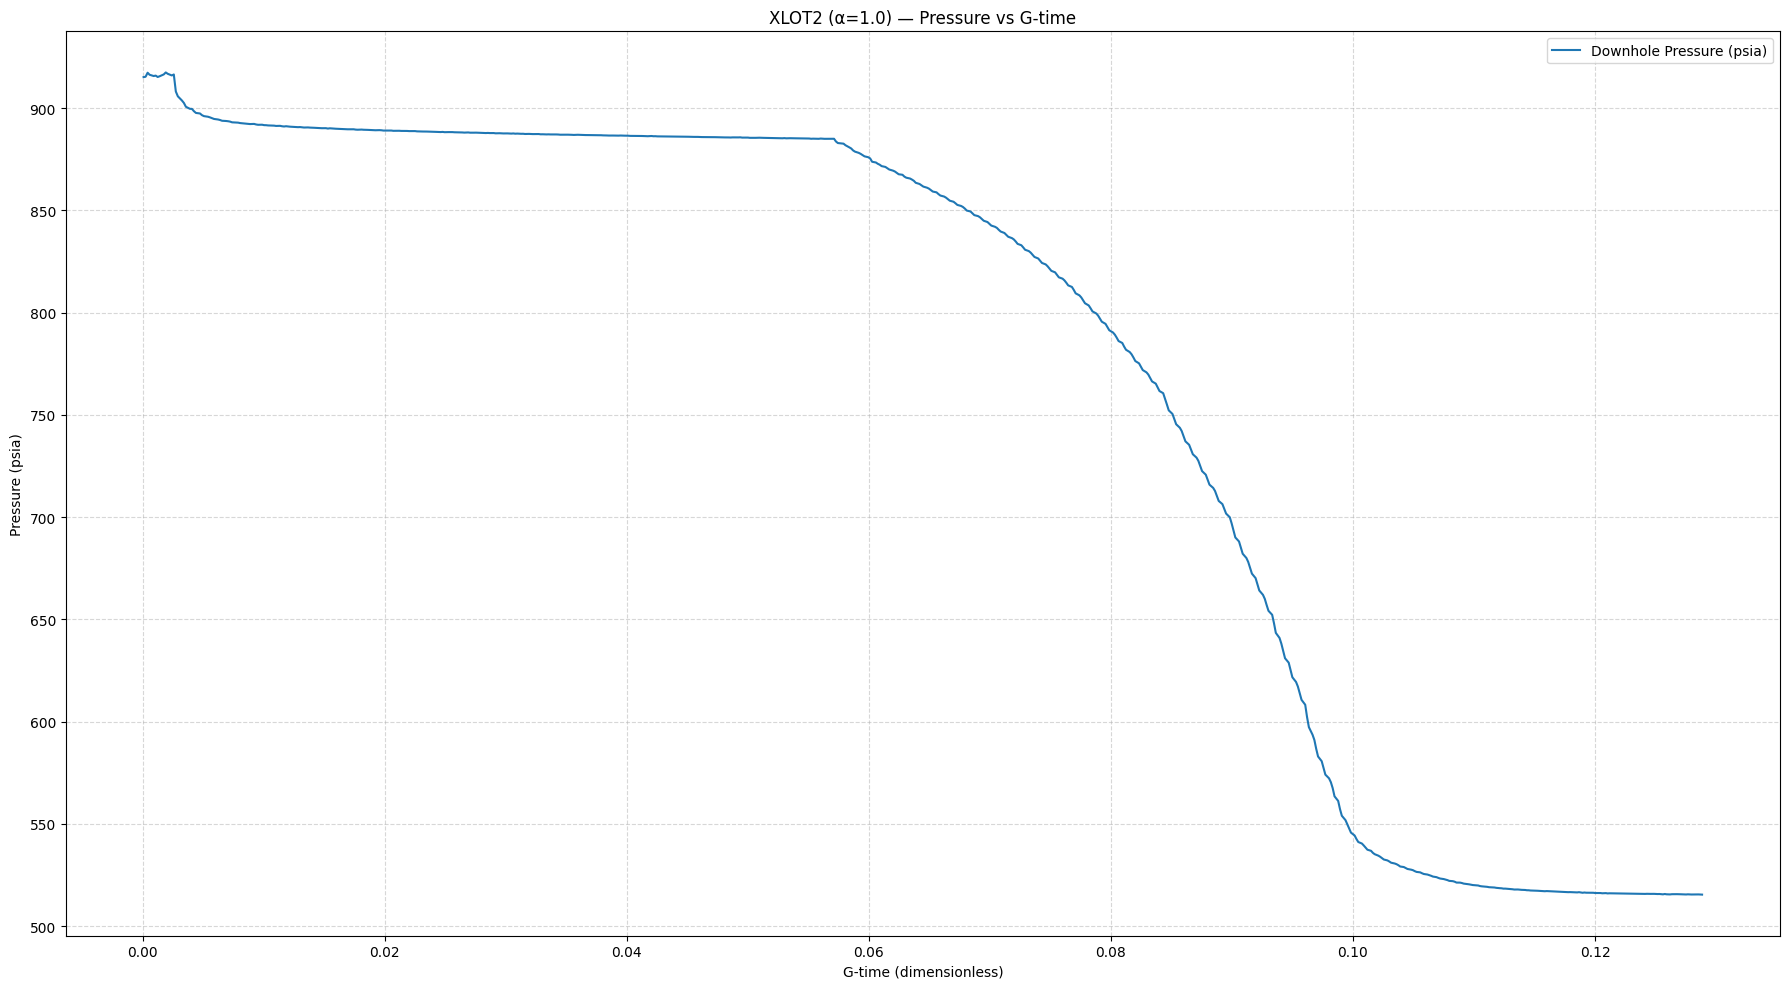

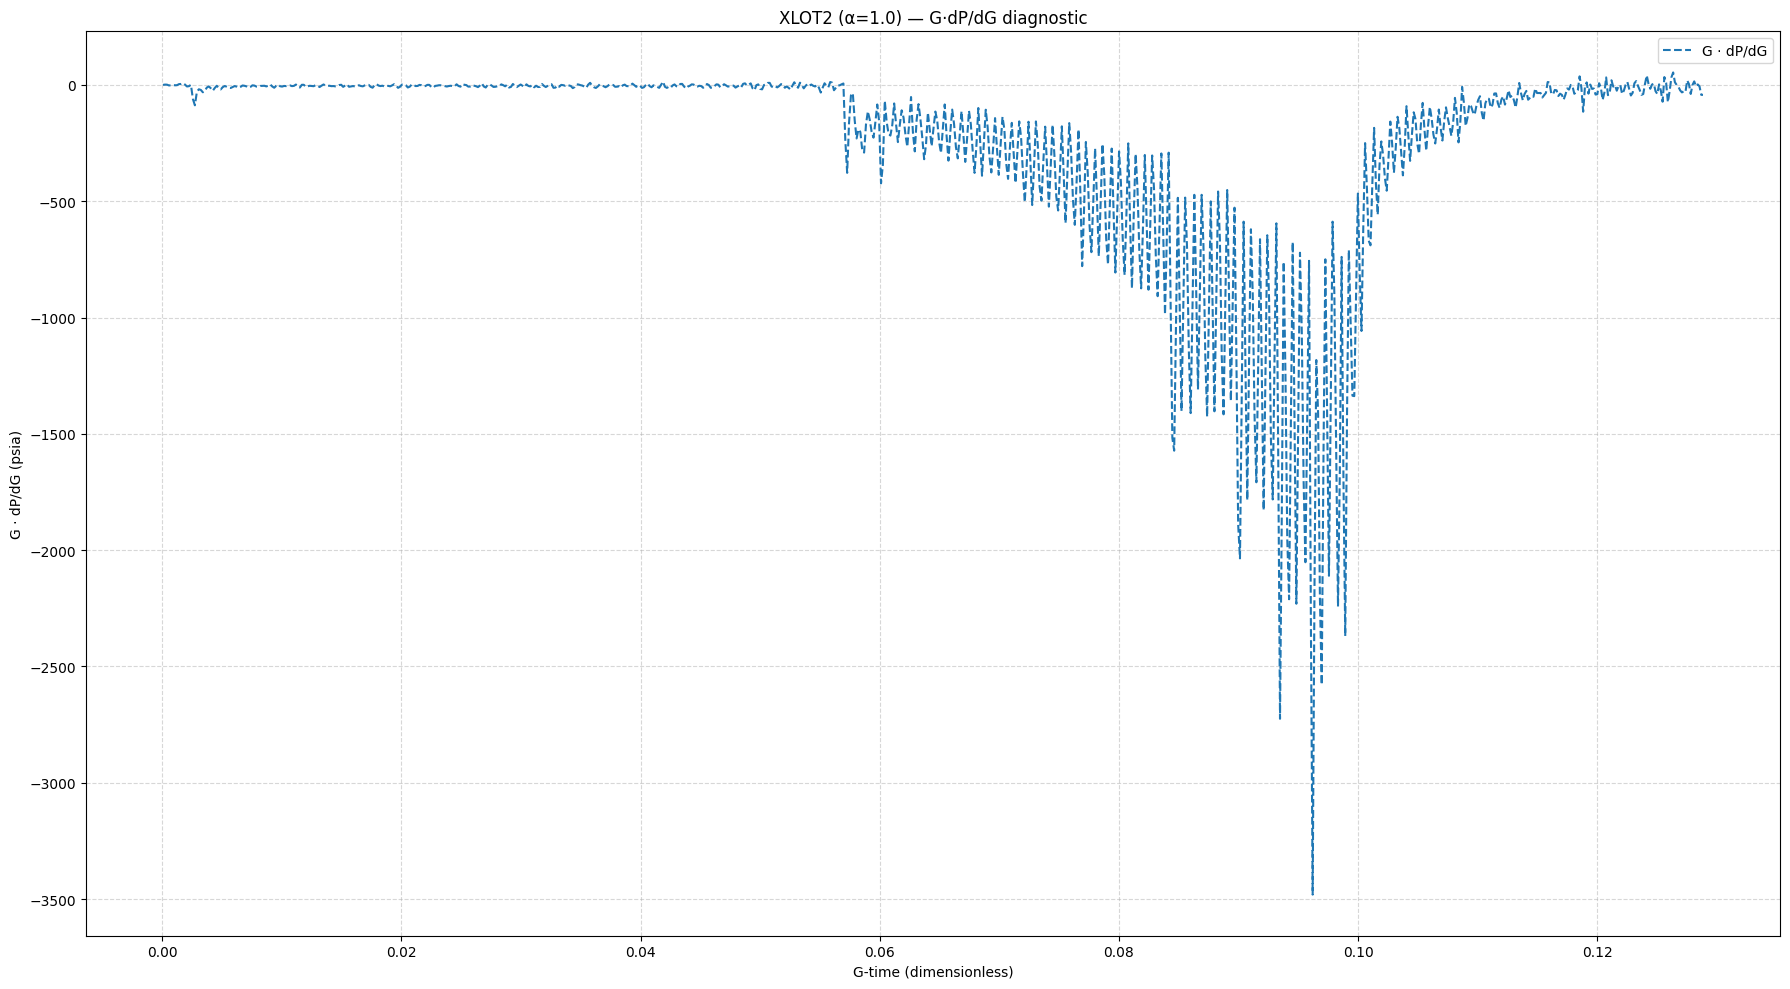

In [2]:
import numpy as np


#get the g-function start right after the injection stops, for each cycle
# -------------------------------
# G-function utilities (Nolte)
# -------------------------------
def compute_pumping_window(cmt_df, rate_col="CMT_RATE_Lmin", threshold=0.1):
    """
    Return injection start (first time rate > threshold) and shut-in time (last time rate > threshold).
    """
    c = cmt_df.dropna(subset=[rate_col, "DateTime"]).sort_values("DateTime")
    mask = (c[rate_col].astype(float) > threshold)
    if not mask.any():
        raise RuntimeError(f"No pumping period found using threshold={threshold} on column={rate_col}.")
    inj_times = c.loc[mask, "DateTime"]
    t_start = inj_times.iloc[0]
    t_shutin = inj_times.iloc[-1]
    return t_start, t_shutin

def g_time(delta_t_sec, tp_sec, alpha=1.0):
    """
    Nolte G-time (post shut-in). delta_t_sec and tp_sec are in seconds.
    Two limiting cases commonly used in practice:
      - alpha = 1.0: G = ln(1 + Δt/tp)
      - alpha = 0.5: G = 2*(sqrt(1 + Δt/tp) - 1)
    For general alpha:
      G = ((1 + Δt/tp)**(1 - alpha) - 1) / (1 - alpha), alpha != 1
    """
    x = np.asarray(delta_t_sec, dtype=float) / float(tp_sec)
    if alpha == 1.0:
        return np.log1p(x)
    elif alpha == 0.5:
        return 2.0 * (np.sqrt(1.0 + x) - 1.0)
    else:
        return ((1.0 + x)**(1.0 - alpha) - 1.0) / (1.0 - alpha)

def build_g_function_dataframe(gauge_seg, cmt_seg, rate_col="CMT_RATE_Lmin",
                               threshold=0.1, alpha=1.0):
    """
    Build a DataFrame with post-shut-in pressure and corresponding G-time.
    """
    # Identify pumping window
    t_start, t_shutin = compute_pumping_window(cmt_seg, rate_col=rate_col, threshold=threshold)
    tp_sec = (t_shutin - t_start).total_seconds()
    if tp_sec <= 0:
        raise RuntimeError("Computed pumping time tp <= 0; check cementing data and thresholds.")

    # Keep post-shut-in gauge data only
    g = gauge_seg.dropna(subset=["DateTime", "Pressure_psia"]).sort_values("DateTime")
    g_post = g[g["DateTime"] >= t_shutin].copy()
    if g_post.empty:
        raise RuntimeError("No post-shut-in gauge data found for G-function transform.")

    # Δt from shut-in, then G(Δt)
    dts = (g_post["DateTime"] - t_shutin).dt.total_seconds().to_numpy()
    G = g_time(dts, tp_sec, alpha=alpha)

    out = g_post.copy()
    out["G_time"] = G
    out["DeltaT_sec"] = dts
    out.attrs["t_start_injection"] = t_start
    out.attrs["t_shutin"] = t_shutin
    out.attrs["tp_sec"] = tp_sec
    out.attrs["alpha"] = alpha
    return out

def plot_pressure_vs_G(g_df, title, out_path):
    """
    Plot Pressure vs G-time, plus the diagnostic G*dP/dG as a second figure.
    """
    if g_df.empty:
        print(f"Skipping P vs G for {title}: empty dataframe.")
        return

    # Sort by G, ensure monotonic
    d = g_df.dropna(subset=["G_time", "Pressure_psia"]).sort_values("G_time")
    G = d["G_time"].to_numpy()
    P = d["Pressure_psia"].to_numpy()

    # ---- Plot 1: Pressure vs G
    fig1, ax1 = plt.subplots(figsize=(18, 10))
    ax1.plot(G, P, label="Downhole Pressure (psia)")
    ax1.set_xlabel("G-time (dimensionless)")
    ax1.set_ylabel("Pressure (psia)")
    ax1.grid(True, linestyle="--", alpha=0.5)
    ax1.legend(loc="best")
    ax1.set_title(f"{title} — Pressure vs G-time")
    plt.tight_layout()
    fig1.savefig(out_path.replace(".png", "_P_vs_G.png"), dpi=150, bbox_inches="tight")

    # ---- Plot 2: G * dP/dG diagnostic
    # Numerical derivative dP/dG; handle non-uniform spacing safely
    dG = np.gradient(G)
    dP = np.gradient(P)
    with np.errstate(divide="ignore", invalid="ignore"):
        dP_dG = np.where(dG != 0.0, dP / dG, np.nan)
    GdPdG = G * dP_dG

    fig2, ax2 = plt.subplots(figsize=(18, 10))
    ax2.plot(G, GdPdG, linestyle="--", label="G · dP/dG")
    ax2.set_xlabel("G-time (dimensionless)")
    ax2.set_ylabel("G · dP/dG (psia)")
    ax2.grid(True, linestyle="--", alpha=0.5)
    ax2.legend(loc="best")
    ax2.set_title(f"{title} — G·dP/dG diagnostic")
    plt.tight_layout()
    fig2.savefig(out_path.replace(".png", "_GdPdG.png"), dpi=150, bbox_inches="tight")
    plt.show()

# -------------------------------
# Build & plot G-time for XLOT1 / XLOT2
# -------------------------------
# Choose alpha per IHS/Nolte limiting cases:
#   alpha = 1.0  -> low leakoff / high efficiency (G = ln(1 + Δt/tp))
#   alpha = 0.5  -> high leakoff / low efficiency (G = 2(√(1 + Δt/tp) - 1))
ALPHA = 1.0   # change to 0.5 to test the other limiting case

x1_g = build_g_function_dataframe(gauge_x1_rs, xlot1_df, alpha=ALPHA)  # uses CMT_RATE_Lmin by default
plot_pressure_vs_G(x1_g, f"XLOT1 (α={ALPHA})", "xlot1_pressure_vs_cmt_and_return_rate.png")

x2_g = build_g_function_dataframe(gauge_x2_rs, xlot2_df, alpha=ALPHA)
plot_pressure_vs_G(x2_g, f"XLOT2 (α={ALPHA})", "xlot2_pressure_vs_cmt_and_return_rate.png")
